In [1]:
"""
Stratigraphy column plots for LPSC
Last updated: 2022/02/28 (CJTU)
"""
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from moonpies import moonpies as mp
from moonpies import default_config

FIGDIR = ''  # Full path or '' for default (moonpies/figs)
DATADIR = ''  # Full path or '' for default (moonpies/data)
SEED = '00300'  # Set seed as string or '' to pick first seed from datadir
# COI = 'Faustini'  # Set coldtrap of interest or '' for default ("Haworth")
RUNNAME = '_no_bsed'  # append runname to filename
SAVELITH = False  # Save lith key (to use same layers for multiple runs)
MIN_THICKNESS = 5  # [m] minimum layer thickness
SHOW_HATCHES = False

if RUNNAME == '_bsed':
    DATADIR = '/home/cjtu/projects/moonpies/data/out/220224_mpies/'
elif RUNNAME == '_no_bsed':
    DATADIR = '/home/cjtu/projects/moonpies/data/out/220221_nobsed/'

# Set default config
CFG = default_config.Cfg()

# Set Fig paths
if not FIGDIR:
    FIGDIR = CFG.figspath
FIGDIR = Path(FIGDIR).resolve()

# Set data path
if not DATADIR:
    DATADIR = Path(CFG.outpath).parents[0]
DATADIR = Path(DATADIR)

# Set output path
if not SEED:
    SEED = next(DATADIR.iterdir()).stem
OUTDIR = DATADIR / SEED

# # Set stratigraphy input csv
# if not COI:
#     COI = 'Haworth'


plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['figure.titlesize'] = 14

# Make lithology style dictionary
HATCHES = [
    "/", "O", "\\", "+", 
    "//", "||", "-\\", "xx", 
    "\\\\", "x", "O|", "\\|",
    "o","|","++","OO",
    "O."][::-1]

# Make diverging ice% colormap (gray, white, blue)
# COLORS = ['#8b8c8d', '#ffffff', '#3c8df0']
COLORS = ['#ffffff', '#1f77b4']

def get_continuous_cmap(hex_list, locs=None):
    """
    Returns color map from hex_list, interpolating linearly if locs=None.

    If locs is provided, map each color to its location in locs.
    
    Modified from Kerry Halupka:
    github.com/KerryHalupka/custom_colormap/blob/master/generate_colormap.py
    
    Parameters
    ----------
    hex_list (list): Hex code strings
    locs (list): Locations in [0, 1]. Must start with 0 and end with 1.
    
    Returns
    ----------
    cmp (matplotlib.colors.LinearSegmentedColormap): Color map
    """
    def hex_to_rgb(value):
        """Return rgb from hex """
        value = value.strip("#") # removes hash symbol if present
        lv = len(value)
        return tuple(int(value[i:i + lv//3], 16) for i in range(0, lv, lv//3))

    def rgb_to_dec(value):
        """Return decimal color from RGB (i.e. divide by 256)."""
        return [v/256 for v in value]

    rgbs = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if locs is None:
        locs = list(np.linspace(0, 1, len(rgbs)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        c = [[loc, rgbs[i][num], rgbs[i][num]] for i, loc in enumerate(locs)]
        cdict[col] = c
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

ICE_CM = get_continuous_cmap(COLORS)
# ICE_CM = mpl.cm.get_cmap('Blues')

def get_lith_key(strat, cmap=ICE_CM, savepath=None):
    """Return dict of dict of lithology to label, hatch style and ice_pct"""
    lith_key = {}
    lith_key_saved = {}
    if savepath is not None and Path(savepath).exists():
        with open(savepath, 'r') as f:
            lith_key_saved = json.load(f)
    # Loop through every second row in strat (since strat is lith edges)
    for i, row in strat.iloc[1::2].iterrows():
        label = row.label
        ice_pct = row.icepct
        if label == "Ice":
            lith_id = -1
            hatch = '.'
            ice_pct = 100
        else:
            if label in lith_key_saved:
                hatch = lith_key_saved[label]['hatch']
            else:
                hatch = HATCHES[i%len(HATCHES)]
            lith_id = i    
        lith_key[label] = {'lith': lith_id, 'hatch': hatch, 'ice_pct': ice_pct}
    if savepath is not None:
        with open(savepath, 'w') as f:
            json.dump(lith_key, f)
    return lith_key


#Setting up definitions for strat columns
def clean_up_strat_col(strat_col, thick_thresh=MIN_THICKNESS):
    """
    Clean up strat_col by removing thin layers 
    """
    thick = -np.diff(np.append(strat_col.depth.values, 0))
    strat_col = strat_col.drop(strat_col[thick < thick_thresh].index)
    agg = {"ice": "sum", "ejecta": "sum", "label": "last", "time": "last", "depth": "last"}
    strat = mp.merge_adjacent_strata(strat_col, agg)
    strat["icepct"] = np.round(100 * strat.ice / (strat.ice + strat.ejecta), 4)
    return strat


def get_strat_col_ranges(strat_col, savefile=None):
    """Return strat_col ranges for strat_col plot"""
    # Make into ranges
    strat = pd.concat((strat_col.copy(), strat_col.copy()))
    strat = strat.sort_values('depth')
    strat = strat.iloc[:-1]
    top = strat.iloc[0:1]
    top.loc[:, ['depth', 'ejecta', 'ice', 'time']] = (0,0,0,0)
    strat = pd.concat((top, strat))
    strat['label'] = pd.concat((strat.iloc[1:]['label'], strat.iloc[-1:]['label'])).values

    if savefile:
        strat.to_csv('strat_output.csv')
    return strat

def makekey(lith_key, savepath, ncols=1, show_ict_pct=False, key_color='white', cmap=ICE_CM):
    """Plot lithology legend"""
    x = [0, 1]
    y = [1, 0]

    # Set up rows / cols and axes
    nrows = int(np.ceil(len(lith_key)/ncols))
    xsize = 1.5*ncols
    ysize = 9 #nrows * 1.5
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, 
                             figsize=(xsize, ysize), 
                             gridspec_kw = {'wspace':0, 'hspace':1},
                             subplot_kw={'xticks':[], 'yticks':[]})
    
    norm = mpl.colors.Normalize(vmin=0, vmax=100)
    for i, (ax, (label, v)) in enumerate(zip(axes.flat, lith_key.items())):
        if label != "Ice" and show_ict_pct:
            label += f" Ejecta ({v['ice_pct']:.0f}% ice)"
        if key_color != 'white':
            key_color = cmap(norm(v['ice_pct']))
        ax.plot(x, y, linewidth=0)
        ax.fill_betweenx(y, 0, 1, facecolor=key_color, hatch=v["hatch"])
        ax.set_xlim(0, 0.1)
        ax.set_ylim(0, 1)
        # Turn off invisible axes
        if i >= len(lith_key):
            for a in ax.spines.values():
                a.set_visible(False)
        ax.set_title(label, size=10)
    fig.savefig(savepath, dpi=300)
    print(f"Saved key to {savepath}")

# Read strat and initialize
cfg = default_config.Cfg(seed=float(SEED))
rng = mp.get_rng(cfg)
crater_list = mp.get_crater_list(cfg=cfg, rng=rng)

COIS = ['Haworth', 'Shoemaker', 'Faustini', 'Cabeus']

/home/cjtu/projects/moonpies/.venv/lib/python3.8/site-packages/pandas/core/indexing.py:1797: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, v, pi)
/tmp/ipykernel_6002/2421536475.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(savepath, bbox_inches="tight", dpi=300)


Saved strat col plot to /home/cjtu/projects/moonpies/figures/strat_00300_no_bsed.png
Bot depth: 1099.3151


/home/cjtu/projects/moonpies/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


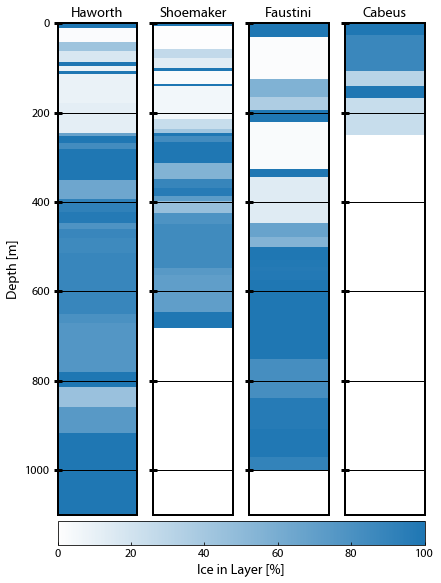

In [2]:
# Init strat col plot
fig = plt.figure(figsize=(1.5*len(COIS), 8), constrained_layout=True)
gs = fig.add_gridspec(2, len(COIS), wspace=0.01, hspace=0.01,  height_ratios=[1, 0.05])
axs = []
for i, coi in enumerate(COIS):
    axs.append(fig.add_subplot(gs[0, i]))
cax = fig.add_subplot(gs[1, :])

savepath = FIGDIR / f'strat_{SEED}{RUNNAME}.png'
bot_depth = 1099.3151  # scale all cold traps to same depth
for i, coi in enumerate(COIS):
    csv = OUTDIR / f'strat_{coi}.csv'
    coi_strat = pd.read_csv(csv)
    formation_age = crater_list[crater_list.cname == coi].age.values[0]
    coi_strat = coi_strat[coi_strat.time < formation_age]

    #Make strat col and plots
    coi_strat = clean_up_strat_col(coi_strat)
    strat = get_strat_col_ranges(coi_strat)

    #Get lith key and dict of lithology:numerical key
    lith_key = get_lith_key(strat)
    lith2key = {k:v["lith"] for k, v in lith_key.items()}
    strat["lith"] = strat["label"].map(lith2key)

    cmap = ICE_CM
    lith_depth_labels = False
    show_hatches = SHOW_HATCHES
    # Get the depth boundaries of each distinct layer in strat
    adj_check = (strat.label != strat.label.shift()).cumsum()
    distinct_layers = strat.groupby(['label', adj_check], as_index=False,
                                sort=False).agg({"depth" : ['max'], "time": ['max']})
    yticks_depth = distinct_layers.depth['max'].values
    yticks_depth = np.insert(yticks_depth, 0, 0)  #Add zero to start

    yticks_time = distinct_layers.time['max'].values
    yticks_time = np.insert(yticks_time, 0, 0)

    top_depth = 0
    if yticks_depth.max() > bot_depth:
        bot_depth = yticks_depth.max()

    ax1 = axs[i]
    ax1.set_xlim(0, 1)
    ax2 = ax1.twinx()

    # Plot strat layers
    norm = mpl.colors.Normalize(vmin=0, vmax=100)
    for k, v in lith_key.items():
        color = cmap(norm(v['ice_pct']))
        hatch = v['hatch'] if show_hatches else None
        ax1.fill_betweenx(strat["depth"], 0, 1, ec=None, where=(strat["lith"] == v['lith']), 
                            facecolor=color, hatch=hatch)

    # Configure axes (ax1 = absolute depth [m], ax2 = lith depth [m])
    ax1.set_title(f"{coi}")
    # ax1.grid(False)
    ax1.grid(color='k', lw=1)
    ax1.tick_params(axis='y', length=8, width=0.5, direction='inout')

    # Draw lines between strat layers
    # ax2.set_yticks(yticks_depth)
    # ax2.grid(which="major", color="black", linestyle="-", linewidth=2)

    if lith_depth_labels:
        ax2.set_ylabel('Lithology Depths [m]', labelpad=25, rotation=-90)
    else:
        ax2.grid(False)
        ax2.set_yticklabels([])
        ax2.tick_params(axis='y', width=0)

for i, ax in enumerate(axs):
    ax.set_ylim(bot_depth, top_depth)
    ax.tick_params(axis='y', width=3)
    ax.xaxis.set_visible(False)
    ax.spines["top"].set_position(("axes", 1.0))
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
        if i > 0:
            ax.set_yticklabels([])
axs[0].set_ylabel('Depth [m]', labelpad=5)
axs[0].yaxis.get_major_formatter().set_scientific(False)
    # Make colorbar
norm = mpl.colors.Normalize(vmin=0, vmax=100)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(sm, cax=cax, orientation='horizontal', label='Ice in Layer [%]')
fig.savefig(savepath, bbox_inches="tight", dpi=300)
print(f"Saved strat col plot to {savepath}")
print(f"Bot depth: {bot_depth}")
plt.show()


In [3]:
coi_strat

,ice,ejecta,label,time,depth,icepct
0,14.686847,44.801920,"Imbrium,Schrodinger",3.870000e+09,249.582300,24.6884
1,45.760675,0.000000,Ice,3.810000e+09,166.473790,100.0000
2,10.260666,22.294306,Orientale,3.800000e+09,139.664300,31.5180
3,19.123444,2.662716,Scott,3.790000e+09,107.109330,87.7779
4,72.671826,0.000000,Ice,3.380000e+09,25.973843,100.0000


In [4]:
coi_strat

,ice,ejecta,label,time,depth,icepct
0,14.686847,44.801920,"Imbrium,Schrodinger",3.870000e+09,239.854580,24.6884
1,40.222894,0.000000,Ice,3.810000e+09,162.283840,100.0000
2,10.260666,22.294306,Orientale,3.800000e+09,135.474370,31.5180
3,19.123444,2.662716,Scott,3.790000e+09,102.919390,87.7779
4,72.337192,0.000000,Ice,3.380000e+09,25.495323,100.0000
